In [79]:
import zipfile
with zipfile.ZipFile('./dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./images')

In [80]:
!pip install tensorflow
!pip install keras

In [81]:
import tensorflow as tf
import keras

In [82]:
PATH = './images/images/collectedimages'
CLASS_NAMES = ['hello', 'fine', 'no', 'thankyou', 'yes']
BATCH_SIZE = 32

Splitting the dataset into train, test and validation

In [83]:
!pip install split-folders

In [84]:
import splitfolders
import os
print(os.listdir(PATH))

['no', 'thankyou', 'hello', 'yes', 'fine']


In [118]:
splitfolders.ratio(PATH,seed=1337, output='Split_Data', ratio=(0.6, 0.2, 0.2))

Copying files: 300 files [00:00, 3018.45 files/s]


Prepare the dataset for training

In [123]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'Split_Data/train/',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 120 files belonging to 5 classes.


In [124]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/val/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 60 files belonging to 5 classes.


In [146]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/test/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 30 files belonging to 5 classes.


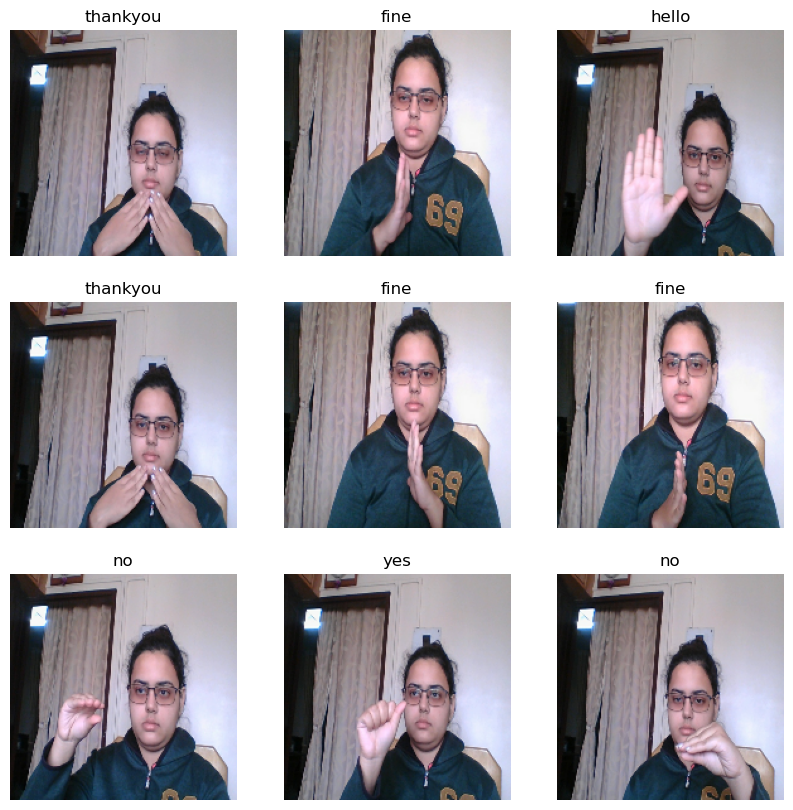

In [125]:
import matplotlib.pyplot as plt

class_names = ['hello', 'fine', 'no', 'thankyou', 'yes']
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [126]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)
])

In [127]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [128]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [130]:
history = model.fit(
  dataset,
  batch_size=BATCH_SIZE,
  validation_data=validation_dataset,
  epochs=10
)

Epoch 1/10
4/4 [==============================] - 1s 132ms/step - loss: 0.2641 - accuracy: 0.9167 - val_loss: 0.3025 - val_accuracy: 0.8667
Epoch 2/10
4/4 [==============================] - 1s 130ms/step - loss: 0.2475 - accuracy: 0.8917 - val_loss: 0.3014 - val_accuracy: 0.8667
Epoch 3/10
4/4 [==============================] - 1s 127ms/step - loss: 0.1995 - accuracy: 0.9250 - val_loss: 0.2528 - val_accuracy: 0.8833
Epoch 4/10
4/4 [==============================] - 1s 127ms/step - loss: 0.2002 - accuracy: 0.9083 - val_loss: 0.1337 - val_accuracy: 0.9500
Epoch 5/10
4/4 [==============================] - 1s 126ms/step - loss: 0.1488 - accuracy: 0.9583 - val_loss: 0.1448 - val_accuracy: 0.9500
Epoch 6/10
4/4 [==============================] - 1s 126ms/step - loss: 0.0833 - accuracy: 0.9833 - val_loss: 0.1164 - val_accuracy: 0.9500
Epoch 7/10
4/4 [==============================] - 1s 130ms/step - loss: 0.1311 - accuracy: 0.9417 - val_loss: 0.2355 - val_accuracy: 0.8833
Epoch 8/10
4/4 [====

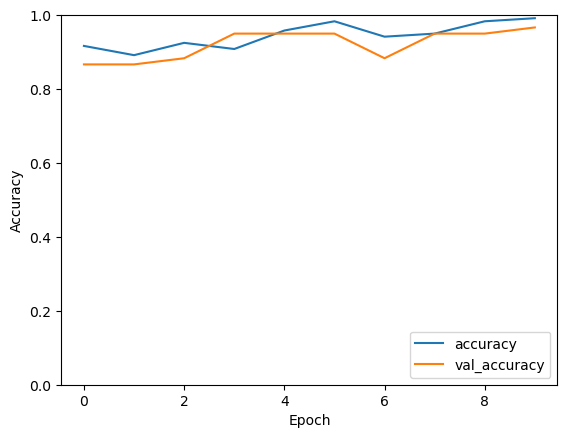

In [131]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Testing


In [161]:
test_accuracy = model.evaluate(test_dataset,steps=624)

624/624 [==============================] - 0s 13us/step - loss: 0.1687 - accuracy: 0.9333


In [150]:
!pip install opencv-python

In [151]:
import cv2

In [152]:
TEST_IMAGE_PATH = 'Split_Data/test/thankyou/thankyou.2e0df4a6-bb53-11ee-859e-2cdb079ec43c.jpg'

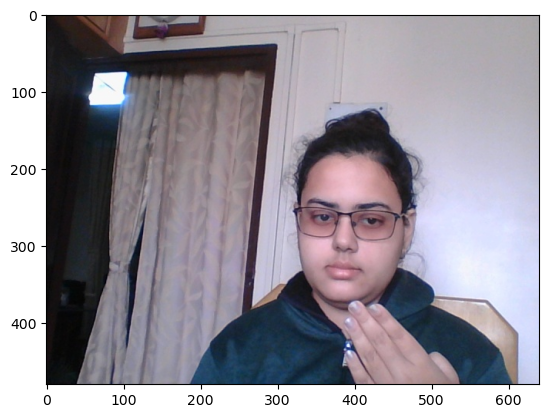

In [153]:
img = cv2.imread(TEST_IMAGE_PATH)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

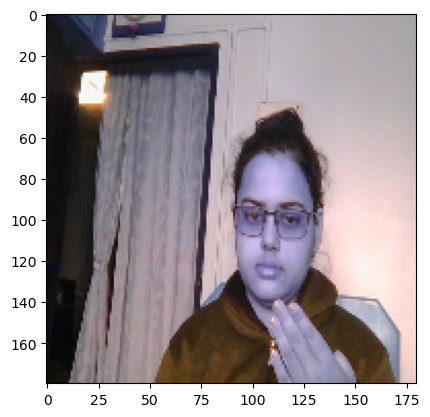

In [154]:
resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [155]:
import numpy as np

In [169]:
prediction = model.predict(np.expand_dims(resize, 0))

1/1 [==============================] - 0s 12ms/step


In [170]:
prediction

array([[ 0.43608811, -5.4143314 ,  0.9741676 ,  5.2670856 ,  1.8250115 ]],
      dtype=float32)

In [172]:
predictions = np.array(prediction)

# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)


if predicted_class_index==0: 
    print(f'Predicted class is Hello')
elif predicted_class_index==1:
    print(f'Predicted class is Fine')
elif predicted_class_index==2:
    print(f'Predicted class is No')
elif predicted_class_index==3:
    print(f'Predicted class is Thank You')
elif predicted_class_index==4:
    print(f'Predicted class is Yes')

Predicted class index: 3
Predicted class is Thank You


In [173]:
model.save('cnn_10ep_ac1.h5')

/Users/shaimahaque/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [160]:
model.save('cnn_10ep_ac1.keras')